# Consumer Complaints Dataset CFPB FL

## Data Preprocessing

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation

import re
import seaborn as sns
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter


# Load the dataset
data = pd.read_csv('CFPB_Complaints_FL.csv')

# Clean the dataset
def clean_dataset(df):
    # Fill NaN values with 0
    df.fillna(0, inplace=True)
    
    # Drop rows where all columns are blank
    df.dropna(how='all', inplace=True)

    # Handle missing values
    df = df.dropna(subset=['Issue', 'Sub-product'])
    
    # Strip any leading or trailing whitespace from column names and values
    df.columns = df.columns.str.strip()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip()
    
    # Handle specific formatting issues
    if 'ZIP code' in df.columns:
        df['ZIP code'] = df['ZIP code'].astype(str).str.zfill(5)
    
    # Drop duplicate rows if any
    df.drop_duplicates(inplace=True)
    
    return df

# Clean "consumer complaint narrative"
# Text cleaning fnct with exclusion patterns
def clean_text_column(df, column_name):
    """
    Clean the text column by removing special characters, lowering case, 
    removing stopwords, and excluding specific patterns.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    exclude_patterns = {
        "xxxx", "xxxx xxxx", "xxxxxxxx", "xxxx xxxx xxxx", 
        "xxxx xxxx xxxx xxxx", "i", "u", "everything", 
        "nothing", "anything", "someone", "mortgage"
    }
    
    def process_text(text):
        # Remove special characters and lowercase the text
        text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
        words = word_tokenize(text)  # Tokenize text
        # Filter out stopwords, exclude patterns, and lemmatize
        words = [
            lemmatizer.lemmatize(word) 
            for word in words 
            if word not in stop_words and word not in exclude_patterns
        ]
        return ' '.join(words)  # Join back into a single string
    
    # Apply processing to the column
    df[column_name] = df[column_name].apply(process_text)
    return df

# Add sentiment scores to the dataset
def add_sentiment_scores(df, column_name):
    """
    Add sentiment polarity and subjectivity scores to the dataset
    based on the specified text column.
    """
    def get_sentiment(text):
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    
    # Apply sentiment analysis to the column
    sentiment_scores = df[column_name].apply(get_sentiment)
    
    # Create new columns
    df['Sentiment_Polarity'] = sentiment_scores.apply(lambda x: x[0])
    df['Sentiment_Subjectivity'] = sentiment_scores.apply(lambda x: x[1])
    
    return df

data = clean_dataset(data)
data = clean_text_column(data, 'Consumer complaint narrative')
data = add_sentiment_scores(data, 'Consumer complaint narrative')

# Save the cleaned dataset to a new file
output_file = 'Cleaned_CFPB_Complaints_FL.csv'
data.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to: {output_file}")

Cleaned dataset saved to: Cleaned_CFPB_Complaints_FL.csv


## Naives Bayes Model

In [167]:
# Define features and target
X = df['Issue']  # Feature (text data)
y = df['Sub-product']  # Target (class labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to numerical features using TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train a Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = nb.predict(X_test_tfidf)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.47043010752688175
Classification Report:
                                             precision    recall  f1-score   support

    Conventional adjustable mortgage (ARM)       0.00      0.00      0.00        43
               Conventional fixed mortgage       0.35      0.85      0.49        73
                Conventional home mortgage       0.53      0.99      0.69       284
                              FHA mortgage       0.23      0.05      0.08       150
        Home equity loan or line of credit       0.00      0.00      0.00        10
Home equity loan or line of credit (HELOC)       0.00      0.00      0.00        39
                            Other mortgage       0.00      0.00      0.00        31
                    Other type of mortgage       0.00      0.00      0.00        33
                          Reverse mortgage       0.00      0.00      0.00         4
                             USDA mortgage       0.00      0.00      0.00         1
               

C:\Users\jazxh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jazxh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jazxh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Sentiment Analysis

C:\Users\jazxh\AppData\Local\Temp\ipykernel_11152\197669662.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sub-product', y='Sentiment', palette='Set2')


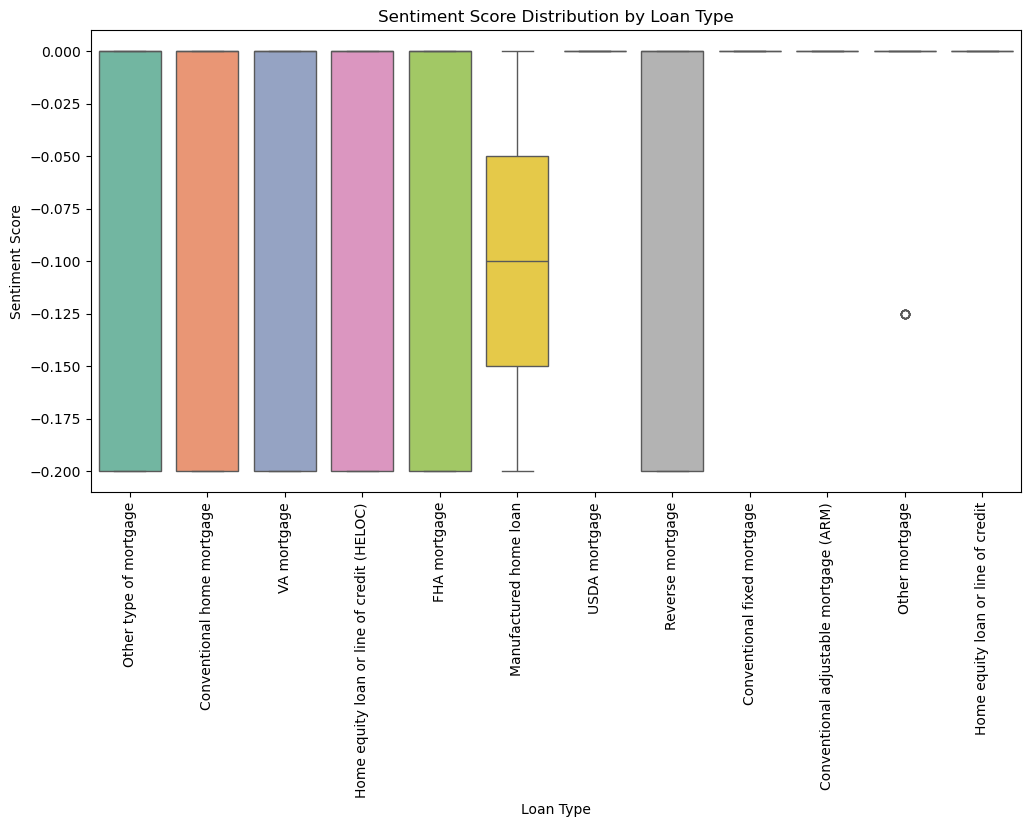

In [169]:
# Add sentiment analysis
def calculate_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['Sentiment'] = df['Issue'].apply(calculate_sentiment)

# Visualize sentiment distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Sub-product', y='Sentiment', palette='Set2')
plt.xticks(rotation=90)
plt.title("Sentiment Score Distribution by Loan Type")
plt.xlabel("Loan Type")
plt.ylabel("Sentiment Score")
plt.show()

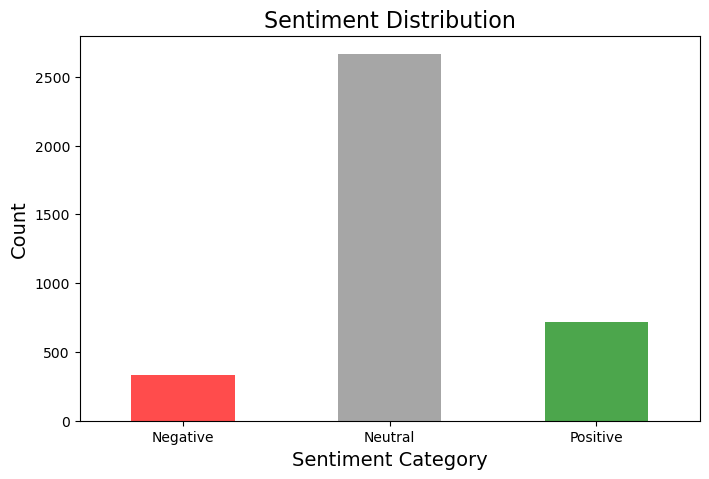

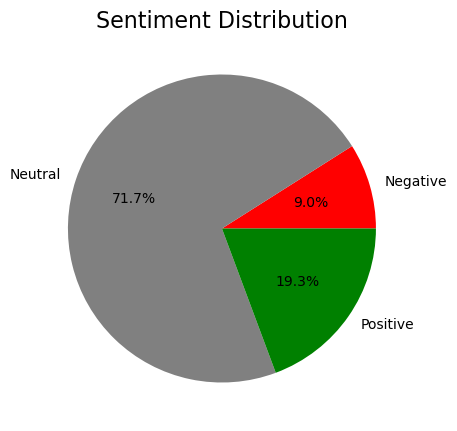

In [173]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Sentiment Analysis
def add_sentiment_scores(df, column_name, sentiment_column_name='Sentiment'):
    """
    Add sentiment scores to the dataset based on the text column.
    """
    df[sentiment_column_name] = df[column_name].apply(
        lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0
    )
    return df

# Extract Key Phrases
def extract_key_phrases_in_chunks(df, column_name, num_phrases=10):
    """
    Extract the most common noun phrases from a text column, excluding specific patterns.
    """
    phrases = []
    exclude_patterns = {"xxxx", "xxxx xxxx", "xxxxxxxx", "xxxx xxxx xxxx", 
        "xxxx xxxx xxxx xxxx", "i", "u", "everything", 
        "nothing", "anything", "someone", "mortgage"}
    
    for text in df[column_name].dropna().astype(str):
        doc = nlp(text)
        phrases.extend([
            chunk.text.strip() 
            for chunk in doc.noun_chunks 
            if chunk.text.strip().lower() not in exclude_patterns
        ])
    
    common_phrases = Counter(phrases).most_common(num_phrases)
    print("Most Common Key Phrases:")
    for phrase, count in common_phrases:
        print(f"{phrase}: {count}")

# Sentiment Visualizations
def plot_sentiment_distribution(df, sentiment_column):
    """
    Plot the sentiment distribution as a bar chart and pie chart.
    """
    categories = ['Negative', 'Neutral', 'Positive']
    df['Sentiment Category'] = pd.cut(
        df[sentiment_column], bins=[-1, -0.1, 0.1, 1], labels=categories
    )
    sentiment_counts = df['Sentiment Category'].value_counts().reindex(categories)
    
    # Bar Chart
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'], alpha=0.7)
    plt.title('Sentiment Distribution', fontsize=16)
    plt.xlabel('Sentiment Category', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=0)
    plt.show()
    
    # Pie Chart
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'gray', 'green'])
    plt.title('Sentiment Distribution', fontsize=16)
    plt.ylabel('')
    plt.show()

# Generate visualizations and perform analyses
plot_sentiment_distribution(data, 'Sentiment')

In [175]:
# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['Sentiment'] = df['Issue'].apply(lambda x: get_sentiment(str(x)))
average_sentiment = df.groupby('Sub-product')['Sentiment'].mean()
print("\nAverage Sentiment by Loan Type:\n", average_sentiment)


Average Sentiment by Loan Type:
 Sub-product
Conventional adjustable mortgage (ARM)        0.000000
Conventional fixed mortgage                   0.000000
Conventional home mortgage                   -0.089356
FHA mortgage                                 -0.056510
Home equity loan or line of credit            0.000000
Home equity loan or line of credit (HELOC)   -0.079775
Manufactured home loan                       -0.100000
Other mortgage                               -0.005525
Other type of mortgage                       -0.065031
Reverse mortgage                             -0.079070
USDA mortgage                                 0.000000
VA mortgage                                  -0.061212
Name: Sentiment, dtype: float64


## Loan Type and Top Keywords

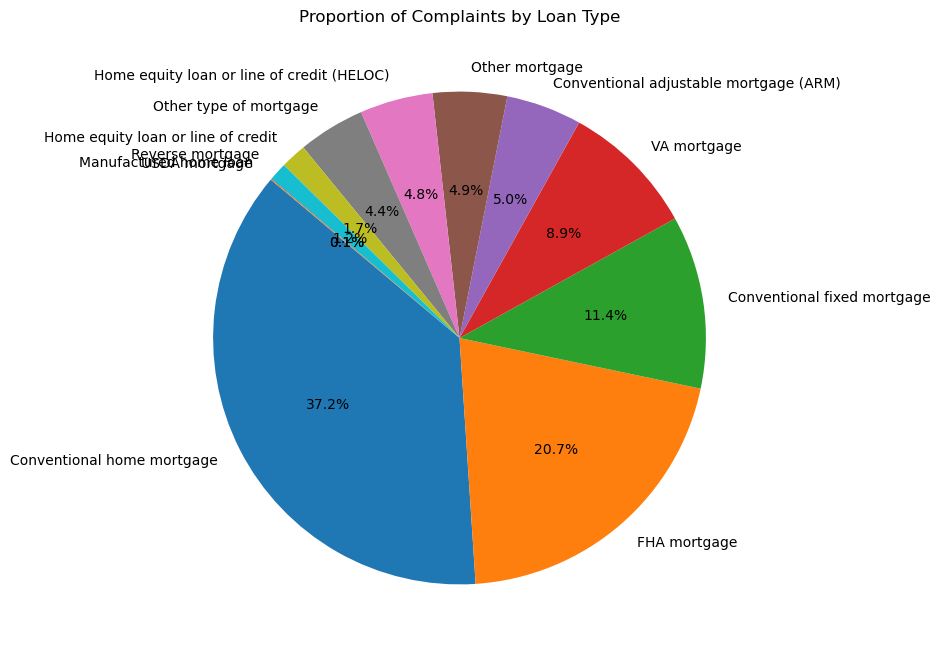

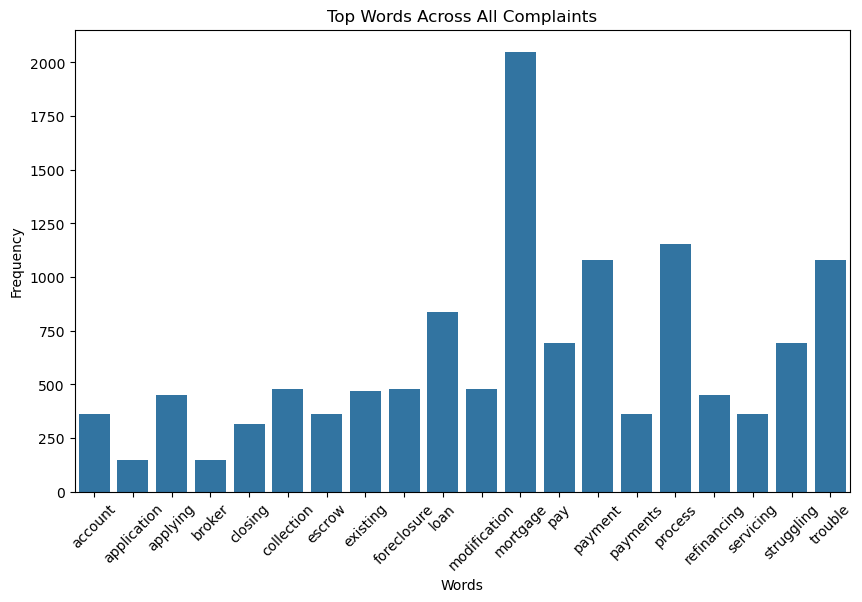

In [177]:
# Pie Chart of Complaints by Loan Type
complaints_by_loan = df['Sub-product'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(complaints_by_loan, labels=complaints_by_loan.index, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Complaints by Loan Type")
plt.show()

# Bar Chart of Common Words Across All Complaints
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_matrix = vectorizer.fit_transform(df['Issue'])
word_counts = word_matrix.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 6))
sns.barplot(x=words, y=word_counts)
plt.title("Top Words Across All Complaints")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

## Heatmap

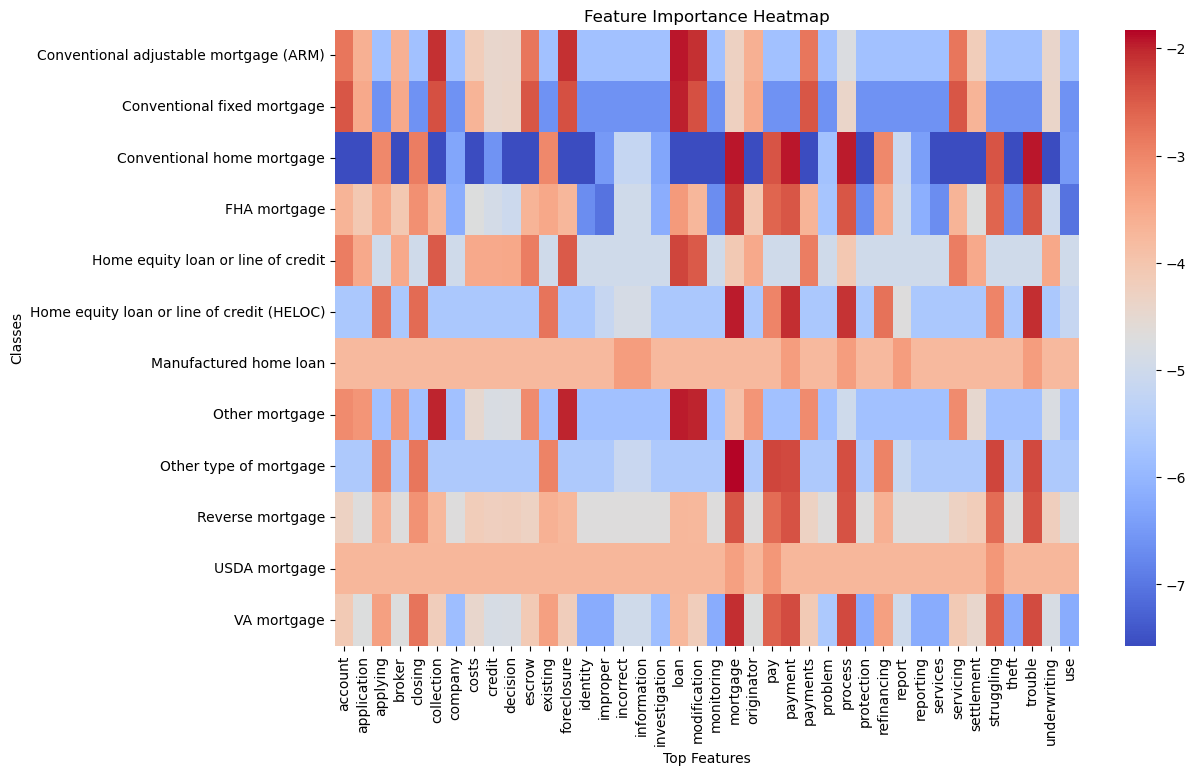

In [179]:
# Feature Importance Heatmap
log_probs = nb.feature_log_prob_  # Log probabilities for each feature and class
feature_names = tfidf.get_feature_names_out()

# Define the number of top features to display
top_features = 10

# Prepare a dictionary for the top words per class
top_words_per_class = {}

for i, class_name in enumerate(nb.classes_):
    top_indices = log_probs[i].argsort()[-top_features:][::-1]  # Indices of top features
    top_words_per_class[class_name] = [feature_names[j] for j in top_indices]

# Create a heatmap data array
heatmap_data = np.zeros((len(nb.classes_), len(feature_names)))

for i, class_name in enumerate(nb.classes_):
    for j, word in enumerate(feature_names):
        heatmap_data[i, j] = log_probs[i, j]

# Visualize top features with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data[:, :50],  # Display only the first 50 features for clarity
    cmap='coolwarm',
    yticklabels=nb.classes_,
    xticklabels=feature_names[:50]
)
plt.title("Feature Importance Heatmap")
plt.xlabel("Top Features")
plt.ylabel("Classes")
plt.show()

In [181]:
# Count complaints by loan type
complaints_by_loan = df['Sub-product'].value_counts()
print("Complaints by Loan Type:\n", complaints_by_loan)

Complaints by Loan Type:
 Sub-product
Conventional home mortgage                    1381
FHA mortgage                                   768
Conventional fixed mortgage                    422
VA mortgage                                    330
Conventional adjustable mortgage (ARM)         184
Other mortgage                                 181
Home equity loan or line of credit (HELOC)     178
Other type of mortgage                         163
Home equity loan or line of credit              63
Reverse mortgage                                43
Manufactured home loan                           2
USDA mortgage                                    2
Name: count, dtype: int64


## Top Complaints

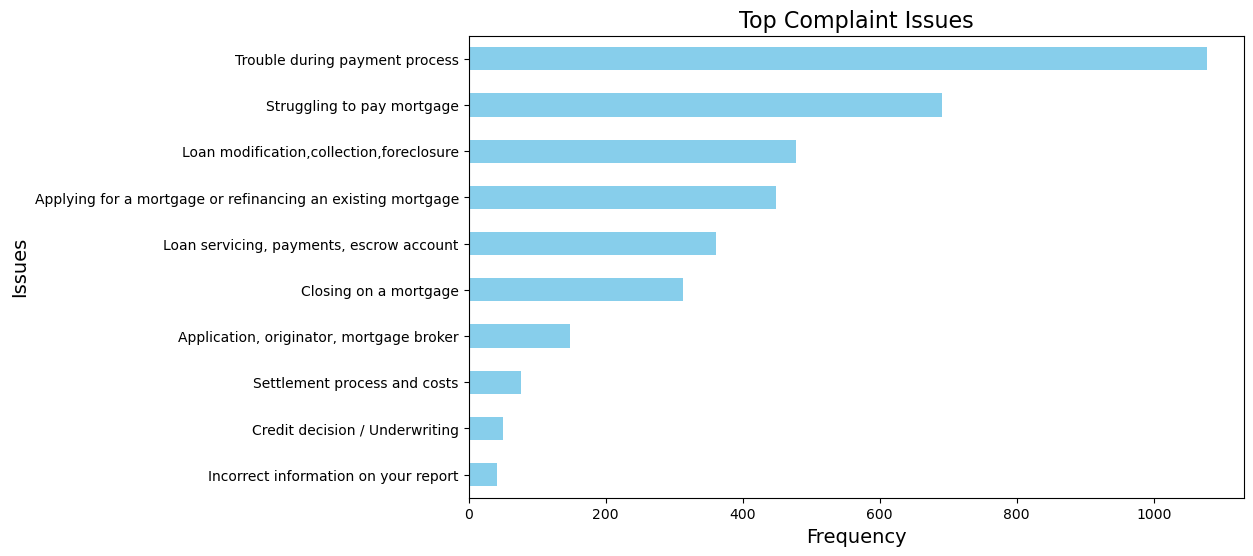

In [183]:
def group_by_issue(df, issue_column, top_n=10):
    issue_counts = df[issue_column].value_counts().head(top_n)

    plt.figure(figsize=(10, 6))
    issue_counts.plot(kind='barh', color='skyblue')
    plt.title('Top Complaint Issues', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Issues', fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

# Example Usage
group_by_issue(data, 'Issue', top_n=10)

In [185]:
# TF-IDF Analysis
tfidf = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = tfidf.fit_transform(df['Issue'].dropna())
features = tfidf.get_feature_names_out()
importance = tfidf_matrix.sum(axis=0).A1
tfidf_scores = pd.DataFrame({'Word': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print("\nTop Words Across All Complaints:\n", tfidf_scores)


Top Words Across All Complaints:
             Word  Importance
11      mortgage  746.380765
15       process  684.994461
19       trouble  628.114140
13       payment  628.114140
18    struggling  439.504827
12           pay  439.504827
9           loan  330.010925
4        closing  276.491968
10  modification  249.666640
8    foreclosure  249.666640
5     collection  249.666640
7       existing  229.920625
16   refinancing  214.625832
2       applying  214.625832
6         escrow  169.086042
14      payments  169.086042
17     servicing  169.086042
0        account  169.086042
1    application   99.991240
3         broker   99.991240


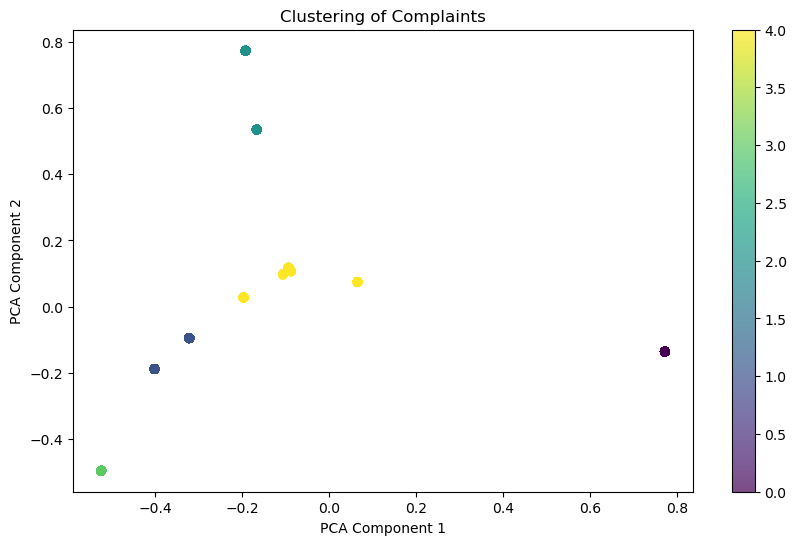

In [187]:
# Clustering of Complaints
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("Clustering of Complaints")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

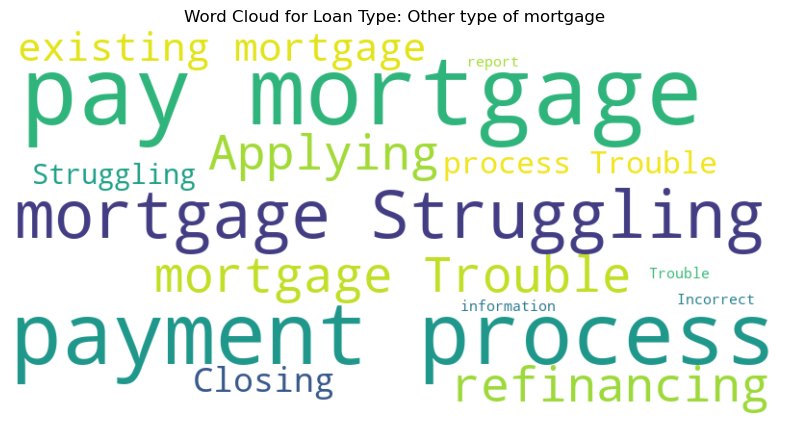

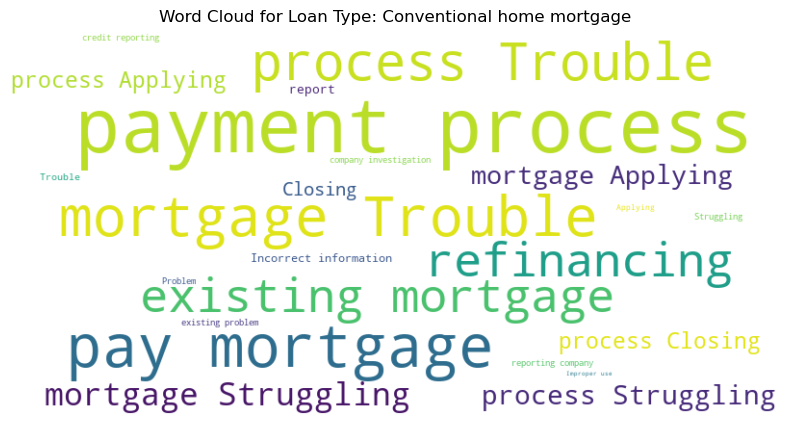

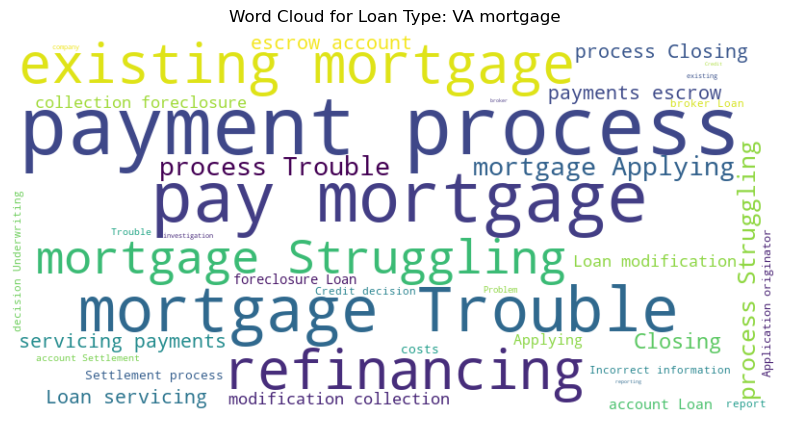

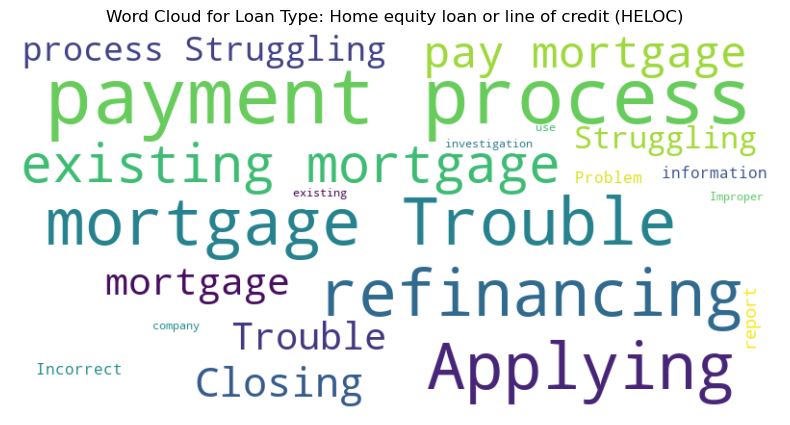

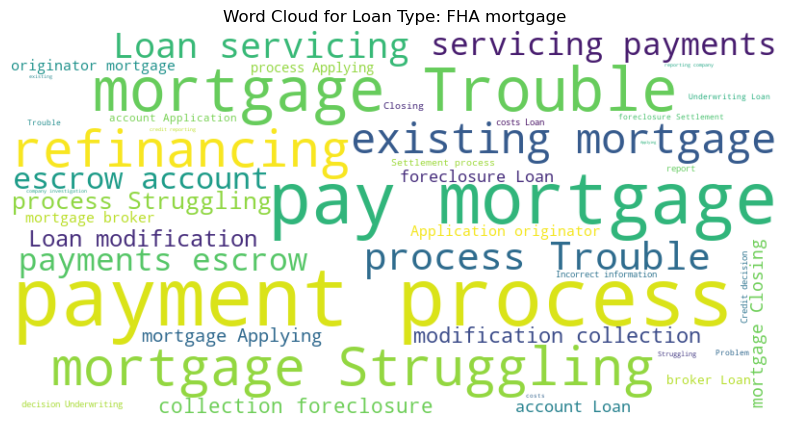

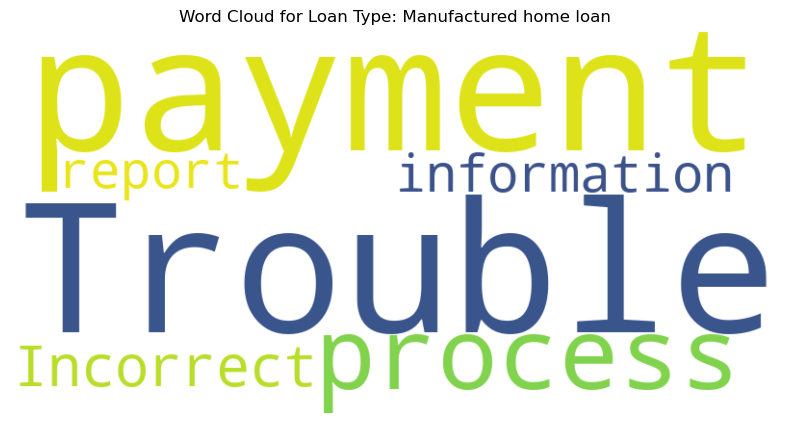

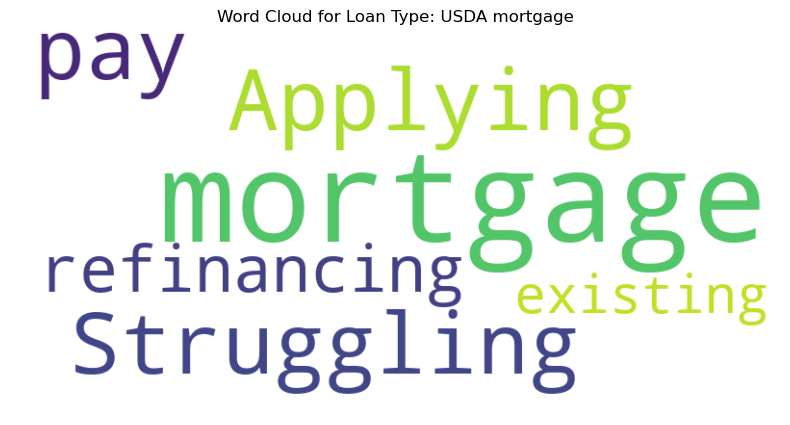

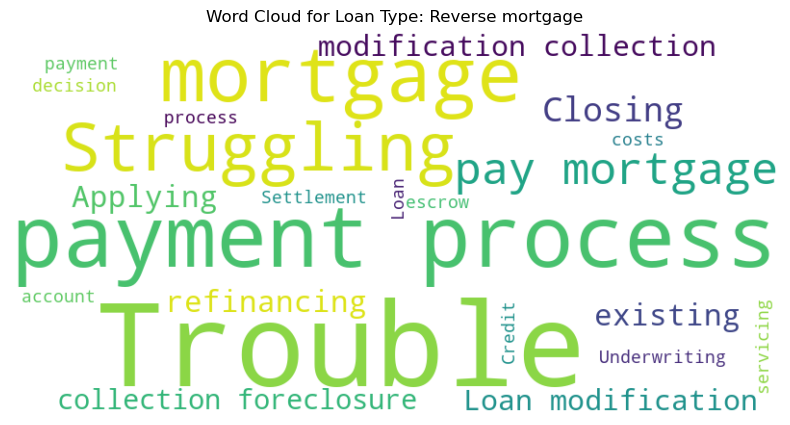

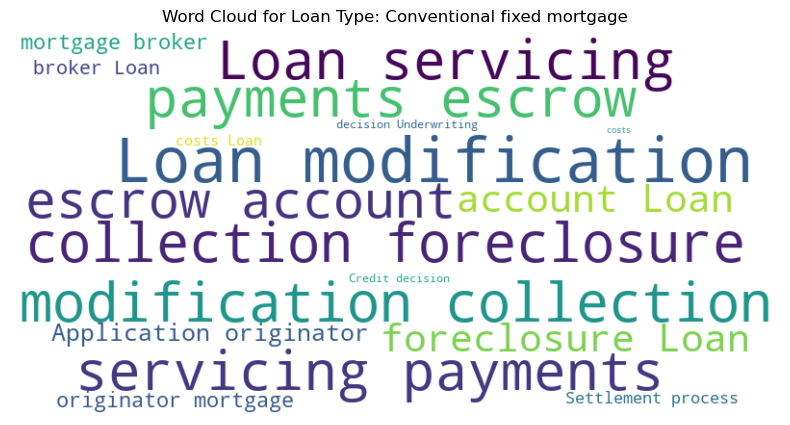

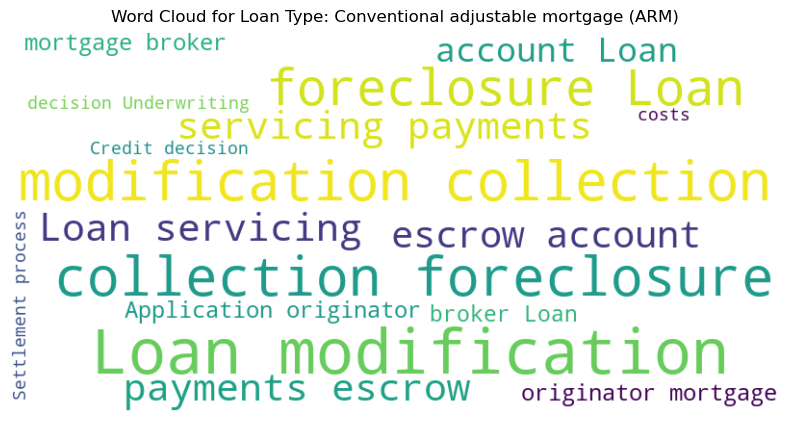

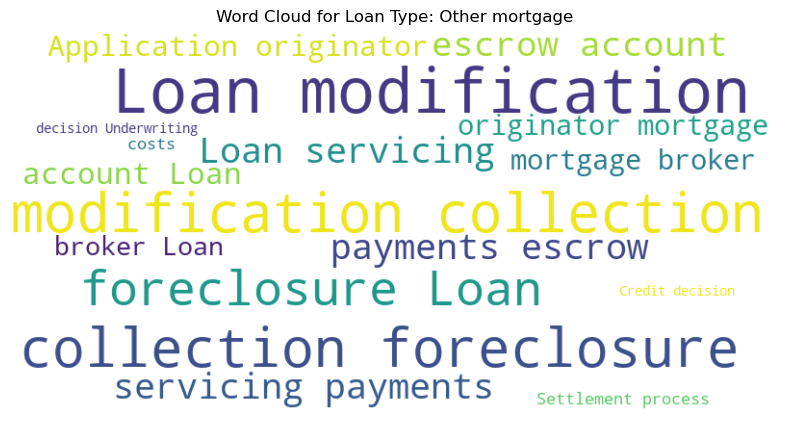

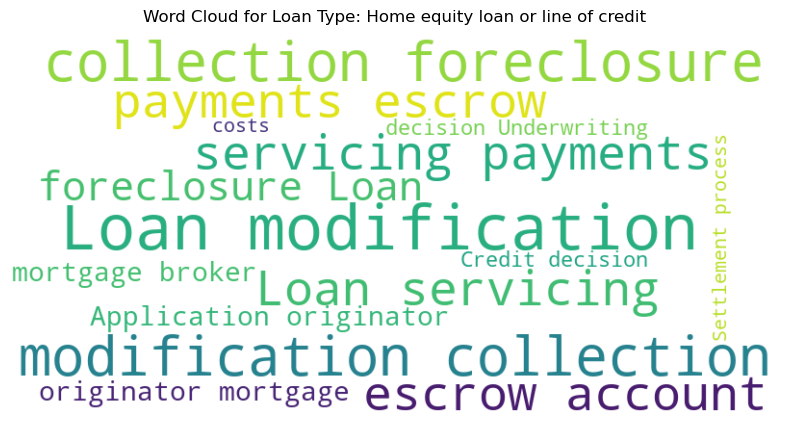

In [189]:
# Word Cloud for Each Class
for loan_type in df['Sub-product'].unique():
    subset = df[df['Sub-product'] == loan_type]['Issue']
    all_text = " ".join(subset.dropna().astype(str))

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Loan Type: {loan_type}")
    plt.show()

## Historical Outlook

C:\Users\jazxh\AppData\Local\Temp\ipykernel_11152\3819412841.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  complaints_over_time = df.resample('M').size()


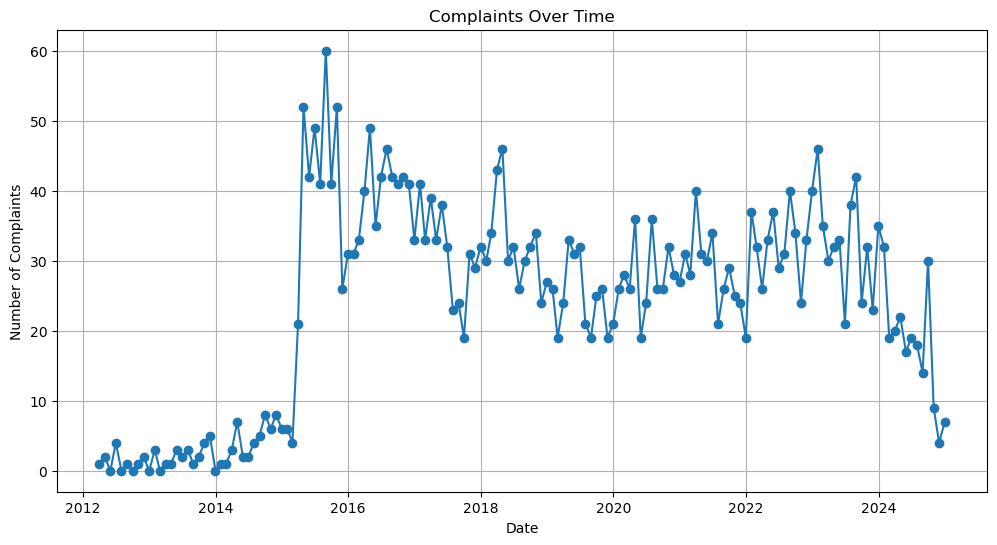

In [196]:
# Time Series Analysis
df['Date received'] = pd.to_datetime(df['Date received'])
df.set_index('Date received', inplace=True)

# Plot complaints over time
complaints_over_time = df.resample('M').size()
plt.figure(figsize=(12, 6))
plt.plot(complaints_over_time.index, complaints_over_time.values, marker='o')
plt.title("Complaints Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Complaints")
plt.grid()
plt.show()

# Summary of Code

## Code Overview:
- **Dataset Loading and Cleaning**:
  - Loads the CFPB consumer complaints dataset.
  - Drops rows with missing values in the `Issue` and `Sub-product` columns.

- **Feature and Target Selection**:
  - Defines `Issue` as the feature (text data) and `Sub-product` as the target (loan type).

- **Text Vectorization**:
  - Converts text data to numerical features using `TfidfVectorizer`.

- **Model Training and Evaluation**:
  - Trains a Naive Bayes model (`MultinomialNB`) on the vectorized text data.
  - Evaluates the model's performance using accuracy and a classification report.

- **Sentiment Analysis**:
  - Adds a `Sentiment` column to the dataset by analyzing the polarity of the `Issue` text.

# Detailed Summary of Code and Visualizations

## Visualizations:
1. **Sentiment Score Distribution**:
   - **Type**: Boxplot
   - **X-axis**: Loan types (`Sub-product`).
   - **Y-axis**: Sentiment scores calculated using TextBlob.
     - **Scale**: Sentiment polarity ranges from -1 (very negative) to +1 (very positive). A score of 0 indicates neutral sentiment.
   - **Purpose**: Helps identify the sentiment trends for complaints across different loan categories. For example, loan types with predominantly negative sentiment scores may need closer examination.

2. **Feature Importance Heatmap**:
   - **Type**: Heatmap
   - **X-axis**: Top 50 features (words) identified by `TfidfVectorizer`.
   - **Y-axis**: Loan types (`Sub-product`).
   - **Color Scale**: Represents the log probabilities of each feature (word) for each class. Higher values indicate greater importance of a word for a specific loan type.
   - **Purpose**: Highlights which words are most associated with each loan type, providing insight into common issues or topics.

3. **Word Clouds**:
   - **Type**: Word Cloud
   - **Content**: Displays the most frequent words for each loan type (`Sub-product`).
   - **Scale**: Word size corresponds to frequency; larger words appear more frequently in complaints.
   - **Purpose**: Provides a visual summary of recurring terms or issues for each loan type, aiding in quick interpretation of consumer concerns.

4. **Complaints Over Time**:
   - **Type**: Line Plot
   - **X-axis**: Time (months).
   - **Y-axis**: Number of complaints (aggregated monthly).
   - **Scale**: Counts of complaints per month.
   - **Purpose**: Identifies trends in complaint frequency over time, which can be useful for detecting seasonal patterns or the impact of policy changes.

5. **Proportion of Complaints by Loan Type**:
   - **Type**: Pie Chart
   - **Content**: Proportions of complaints categorized by loan type (`Sub-product`).
   - **Scale**: Percentage of total complaints.
   - **Purpose**: Highlights which loan types receive the most complaints, helping prioritize areas of focus.

6. **Top Words Across All Complaints**:
   - **Type**: Bar Chart
   - **X-axis**: Top 20 words from all complaints.
   - **Y-axis**: Frequency of each word across the dataset.
   - **Scale**: Absolute counts of word occurrences.
   - **Purpose**: Identifies the most common terms in consumer complaints, which can indicate recurring themes or issues.

7. **Clustering of Complaints**:
   - **Type**: Scatter Plot
   - **X-axis**: PCA Component 1 (reduced dimensionality of textual features).
   - **Y-axis**: PCA Component 2.
   - **Color Scale**: Represents clusters identified by KMeans.
   - **Purpose**: Groups similar complaints based on textual similarity, providing an overview of major themes or categories in the dataset.

## Key Takeaways:
- **Scales and Axes**: Each visualization explicitly defines its axes and color scales, ensuring clarity in interpretation.
- **Insights Provided**:
  - Sentiment analysis for understanding consumer emotions.
  - Feature importance for identifying key complaint topics.
  - Temporal trends for monitoring complaint patterns over time.
  - Clustering for grouping similar complaint types.